In [1]:
import re
import time
import pickle
import os
import numpy as np
import pandas as pd
from itertools import *
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import VarianceThreshold
import datetime
import math
# from plotnine import *
from sklearn.metrics import brier_score_loss
from sklearn.utils import column_or_1d

In [2]:
df = pd.read_csv('../data/tx_cd_23_l2_2016_09_30_featureset_1296.csv', error_bad_lines=False)

In [3]:
df.columns.tolist()

['Unnamed: 0',
 'ispsa',
 'dwelling_type_single_family_dwelling_unit',
 'dwelling_type_multi_family_dwelling',
 'dwelling_type_null',
 'dwelling_unit_size_1_single_family_dwelling',
 'dwelling_unit_size_101',
 'dwelling_unit_size_5_9',
 'dwelling_unit_size_2_duplex',
 'dwelling_unit_size_50_100',
 'dwelling_unit_size_20_49',
 'dwelling_unit_size_3_triplex',
 'dwelling_unit_size_4',
 'dwelling_unit_size_10_19',
 'dwelling_unit_size_null',
 'estimated_income_amount',
 'hh_upscale_buyer',
 'hh_upscale_male_buyer',
 'hh_upscale_female_buyer',
 'hh_book_buyer',
 'hh_family_magazine',
 'hh_female_oriented_magazine',
 'hh_religious_magazine',
 'hh_gardening_magazine',
 'hh_culinary_interest_magazine',
 'hh_health_fitness_magazine',
 'hh_do_it_yourselfer_magazine',
 'hh_financial_magazine',
 'hh_religious_contributor',
 'hh_political_contributer',
 'hh_donates_environment_cause_u',
 'hh_donates_environment_cause_y',
 'hh_donates_environment_cause_null',
 'hh_donates_to_charity_u',
 'hh_donates

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369504 entries, 0 to 369503
Columns: 533 entries, Unnamed: 0 to lalvoterid
dtypes: float64(531), int64(1), object(1)
memory usage: 1.5+ GB


In [5]:
df.shape

(369504, 533)

In [6]:
df.isnull().sum().tolist()

[0,
 61620,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 43704,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 199263,
 194568,
 185358,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 199263,
 281623,
 199263,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 46882,
 61620,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 61620,
 61620,
 61620,
 61620,
 61620,
 61620,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 10858,
 10

In [7]:
print(df.describe())

         Unnamed: 0          ispsa  dwelling_type_single_family_dwelling_unit  \
count  369504.00000  307884.000000                              369504.000000   
mean   184751.50000       3.753758                                   0.497578   
std    106666.76127       3.177943                                   0.499995   
min         0.00000       0.000000                                   0.000000   
25%     92375.75000       1.000000                                   0.000000   
50%    184751.50000       3.000000                                   0.000000   
75%    277127.25000       7.000000                                   1.000000   
max    369503.00000       9.000000                                   1.000000   

       dwelling_type_multi_family_dwelling  dwelling_type_null  \
count                        369504.000000       369504.000000   
mean                              0.183232            0.319190   
std                               0.386857            0.466163   
min   

(array([24731., 24774., 24962., 25288., 24415., 25853., 19663., 25450.,
        26484., 24707., 23292., 20873., 17421., 10140., 10299.,  7494.,
         5273.,  2932.,  1390.,   446.]),
 array([18.  , 21.85, 25.7 , 29.55, 33.4 , 37.25, 41.1 , 44.95, 48.8 ,
        52.65, 56.5 , 60.35, 64.2 , 68.05, 71.9 , 75.75, 79.6 , 83.45,
        87.3 , 91.15, 95.  ]),
 <a list of 20 Patch objects>)

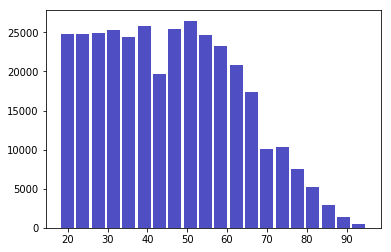

In [8]:
plt.hist(x=df['age'].dropna(), bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

(array([12580.,  6126.,  6025.,  6541.,  6163.,  6016.,  6054.,  6169.,
         6529.,  6143., 12449.,  6487.,  6380.,  6093.,  5825.,  6096.,
         6248.,  6246.,  6275.,  6290., 13288.,  6610.,  6622.,  6431.,
         6226.,  6216.,  6389.,  6619.,  6679.,  6664., 13141.,  6297.,
         6170.,  6160.,  6080.,  6125.,  5817.,  5643.,  5707.,  5390.,
        10470.,  5013.,  5135.,  4606.,  3821.,  3859.,  3797.,  3341.,
         3002.,  2859.,  5113.,  2327.,  2064.,  2089.,  1764.,  1577.,
         1478.,  1373.,  1282.,  1140.,  1707.,   634.,   591.,   442.,
          388.,   302.,   258.,   160.,   132.,   154.]),
 array([18. , 19.1, 20.2, 21.3, 22.4, 23.5, 24.6, 25.7, 26.8, 27.9, 29. ,
        30.1, 31.2, 32.3, 33.4, 34.5, 35.6, 36.7, 37.8, 38.9, 40. , 41.1,
        42.2, 43.3, 44.4, 45.5, 46.6, 47.7, 48.8, 49.9, 51. , 52.1, 53.2,
        54.3, 55.4, 56.5, 57.6, 58.7, 59.8, 60.9, 62. , 63.1, 64.2, 65.3,
        66.4, 67.5, 68.6, 69.7, 70.8, 71.9, 73. , 74.1, 75.2, 76.3, 77

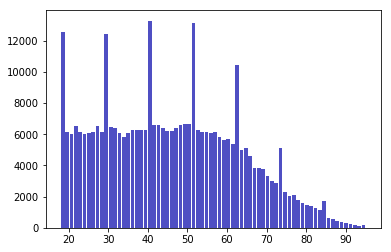

In [9]:
plt.hist(x=df['age'].dropna(), bins=70, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

(array([ 76951., 116714.,  54957.,  37182.,  18428.,   8062.,   2176.,
         11330.]),
 array([  6000.,  36500.,  67000.,  97500., 128000., 158500., 189000.,
        219500., 250000.]),
 <a list of 8 Patch objects>)

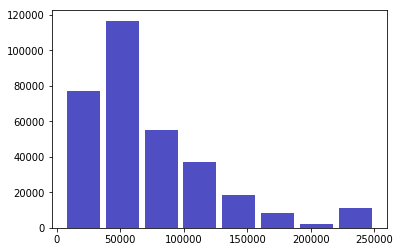

In [10]:
plt.hist(x=df['estimated_income_amount'].dropna(), bins=8, color='#0504aa',
                            alpha=0.7, rwidth=0.85)

(array([251562., 117942.]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

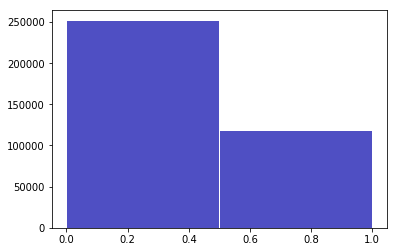

In [11]:
plt.hist(x=df['dwelling_type_null'].dropna(), bins=2, color='#0504aa',
                            alpha=0.7, rwidth=0.99)

In [12]:
import statsmodels.api as sm
model = sm.formula.glm("voted_18g ~ home_purchase_price + age + land_value + estimated_home_value + estimated_median_income",
                       family=sm.families.Binomial(), data=df).fit()
print(model.summary())
#Why is estimated home value insignificant?

                 Generalized Linear Model Regression Results                  
Dep. Variable:              voted_18g   No. Observations:               147268
Model:                            GLM   Df Residuals:                   147262
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -97.262
Date:                Tue, 05 Mar 2019   Deviance:                       194.52
Time:                        10:37:44   Pearson chi2:                 7.28e+04
No. Iterations:                    14   Covariance Type:             nonrobust
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -14.4161      1.639     -8.794      0.000     -17.629     -11.203
home_purchase

In [13]:
import statsmodels.api as sm
model = sm.formula.glm("voted_18g~hh_upscale_buyer+hh_upscale_male_buyer+hh_upscale_female_buyer+hh_book_buyer+hh_family_magazine+hh_female_oriented_magazine+hh_religious_magazine+hh_gardening_magazine+hh_culinary_interest_magazine+hh_health_fitness_magazine+hh_do_it_yourselfer_magazine+hh_financial_magazine+hh_religious_contributor+hh_political_contributer+hh_donates_environment_cause_u+hh_donates_environment_cause_y+hh_donates_environment_cause_null+hh_donates_to_charity_y+hh_donates_to_charity_u+hh_donates_to_charity_null+hh_presence_of_prem_cred_crd_u+hh_presence_of_prem_cred_crd_y+hh_presence_of_prem_cred_crd_null+hh_computer_owner_y+hh_computer_owner_u+hh_computer_owner_null",
                       family=sm.families.Binomial(), data=df).fit()
print(model.summary())
#They are all significant?

/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:879: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:880: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


                 Generalized Linear Model Regression Results                  
Dep. Variable:              voted_18g   No. Observations:               164698
Model:                            GLM   Df Residuals:                   164679
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 05 Mar 2019   Deviance:                          nan
Time:                        10:38:00   Pearson chi2:                 7.21e+16
No. Iterations:                   100   Covariance Type:             nonrobust
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                         -4.542e+22   1.46e+19  -3116.715      0.000   -4.55

/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: divide by zero encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:932: RuntimeWarning: invalid value encountered in multiply
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu)) +
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/marzuqkhan/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/marzuqkhan/anaconda3/lib/pyth

In [14]:
model = sm.formula.glm("voted_18g~ethnicity_european+ethnicity_likely_african_american+ethnicity_hispanic_and_portuguese+ethnicity_other+ethnicity_east_and_south_asian+ethnicity_null",
                       family=sm.families.Binomial(), data=df).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              voted_18g   No. Observations:               345887
Model:                            GLM   Df Residuals:                   345881
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -325.14
Date:                Tue, 05 Mar 2019   Deviance:                       650.28
Time:                        10:38:06   Pearson chi2:                 3.24e+05
No. Iterations:                   100   Covariance Type:             nonrobust
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          4.275e+10   2.25e+12      0.019      0.985   -4.38

In [15]:
model = sm.formula.glm("voted_18g~religion_protestant+religion_catholic+religion_jewish+religion_christian+religion_eastern_orthodox+religion_buddhist+religion_islamic+religion_hindu+religion_greek_orthodox+religion_shinto+religion_lutheran+religion_mormon+religion_sikh+religion_null",
                       family=sm.families.Binomial(), data=df).fit()
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              voted_18g   No. Observations:               345887
Model:                            GLM   Df Residuals:                   345873
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -332.43
Date:                Tue, 05 Mar 2019   Deviance:                       664.87
Time:                        10:38:22   Pearson chi2:                 3.31e+05
No. Iterations:                   100   Covariance Type:             nonrobust
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                 -1.538e+11   7.58e+12     -0.020      0.984    -1.5e+13    1.47e+13
religio

In [16]:
model = sm.formula.glm("voted_18g~occupation_industry_other+occupation_industry_medical+occupation_industry_management+occupation_industry_clericaloffice+occupation_industry_manufacturing+occupation_industry_financial_services+occupation_industry_skilled_trades+occupation_industry_education+occupation_industry_military+occupation_industry_computer_professional+occupation_industry_legal+occupation_industry_engineering+occupation_industry_civil_servant+occupation_industry_food_services+occupation_industry_other_other+occupation_industry_null",
                       family=sm.families.Binomial(), data=df).fit()
print(model.summary())
#Completely insignificant

                 Generalized Linear Model Regression Results                  
Dep. Variable:              voted_18g   No. Observations:               345887
Model:                            GLM   Df Residuals:                   345870
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -334.57
Date:                Tue, 05 Mar 2019   Deviance:                       669.14
Time:                        10:38:28   Pearson chi2:                 3.09e+05
No. Iterations:                    29   Covariance Type:             nonrobust
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   -30.5669   2.63e+05     -